https://h-gens.github.io/automated-drawing-of-the-mos-band-diagram.html

Ev=0.0000eV, Ec=1.1245eV, Ei=0.5585eV, Ef=0.1347eV
phi_s=5.1598eV, phi_ms=-0.1498eV, Vfb=-0.1498eV, Cox=0.0000eV
NMOS Pwell conc:9.9000e+16cm-3, EF=0.1421V, Difference:0.0074V


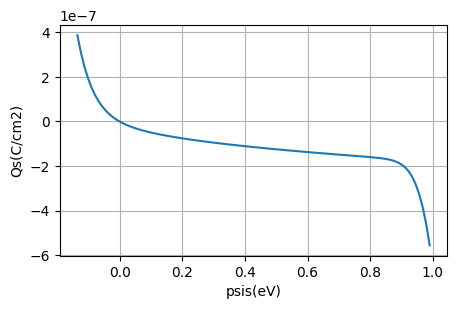

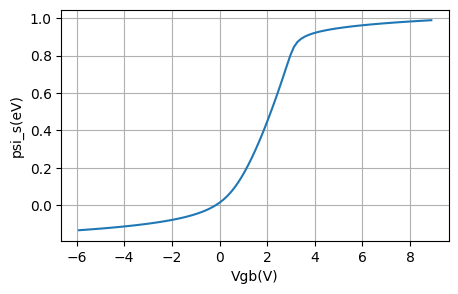

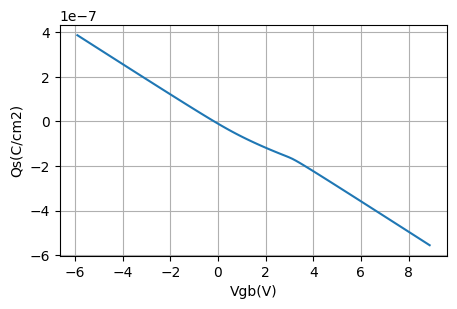

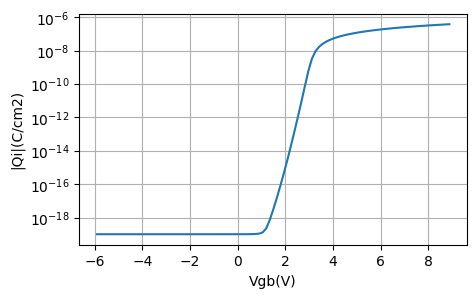

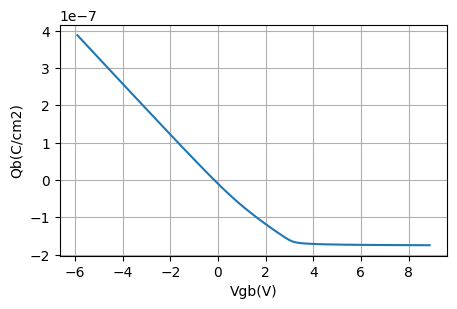

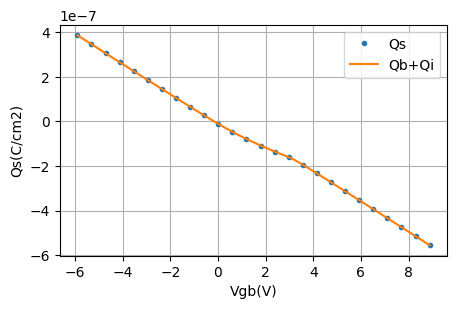

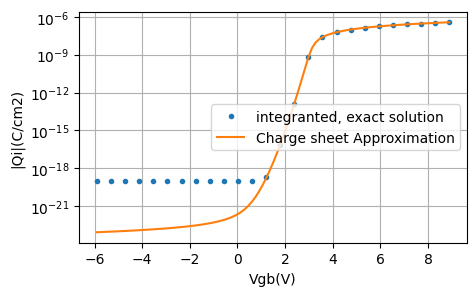

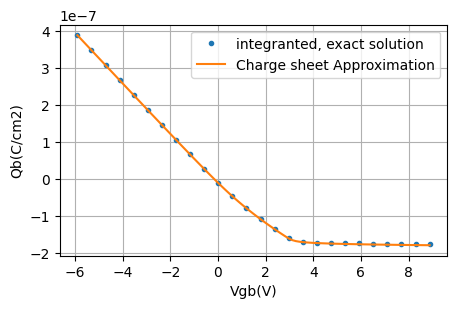

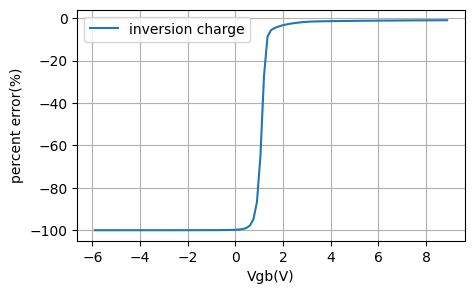

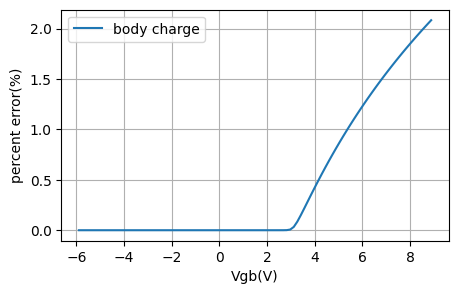

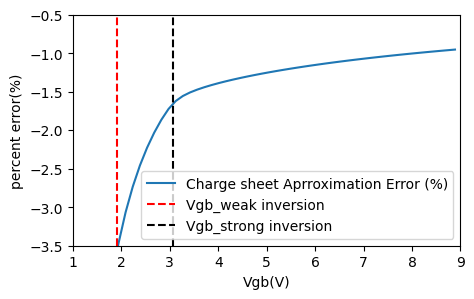

In [25]:
from constant import q,m0,e0,hbar,mn,e_si,k,kB,mp,kT_q,Eg,Nc,Nv,ni,mun,mup,e_ox
import numpy as np, matplotlib.pyplot as plt 
from scipy.integrate import quad

# physical/Design/material parameters
T=300; tox=50e-9*100; ND=1e15; NA=1e17; CBO=3.5; VBO=4.4; es=e_si; eox=e_ox; chi_s=4.17; phi_m=5.01
Eg=Eg(T); Nv=Nv(T); Nc=Nc(T); ni=ni(T); kT=k*T

# create an indicator function
I=lambda x: 1-np.abs(np.sign(x))
# create smoothing functions
def Sp(f,eps=1e-3): 
    return (f+np.sqrt(f**2+4*eps**2))/2.0
def Sn(f,eps=1e-3): 
    return (f-np.sqrt(f**2+4*eps**2))/2.0

# bisection
def solve_bisection(func, target, xmin, xmax, tol=1e-10, max_iters=100):
    a, b = xmin, xmax
    cnt = 0
    while cnt < max_iters:
        c = (a + b) / 2.0
        Fc = target - func(c)
        if np.abs(a - b) < tol or Fc == 0:
            return c
        elif np.sign(target - func(a)) == np.sign(Fc):
            a = c
        else:
            b = c
        cnt += 1
    print('WARNING: max iterations reached')
    return c

# energy level
Ev=0; Ec=Eg; Ei=kT*np.log(ni/Nc)+Ec

# get the fermi level in the bulk where there is no band-bending
n=lambda Ef: Nc*np.exp(-(Ec-Ef)/kT)
p=lambda Ef: Nv*np.exp(-(Ef-Ev)/kT)
func=lambda Ef: p(Ef)-n(Ef)+ND-NA
Ef = solve_bisection(func, 0, Ev, Ec)
print("Ev=%0.4feV, Ec=%0.4feV, Ei=%0.4feV, Ef=%0.4feV" % (Ev,Ec,Ei,Ef))

# semiconductor workfuntion(energy from vaccum to Ef), flatband voltage, oxide cap
phi_s=chi_s+Ec-Ef; phi_ms=phi_m-phi_s; Vfb=phi_ms; Cox=eox*e0/tox
print("phi_s=%0.4feV, phi_ms=%0.4feV, Vfb=%0.4feV, Cox=%0.4feV" % (phi_s,phi_ms,Vfb,Cox))

# use the previous Ef to compute equilibrium carrier concentrations
no=Nc*np.exp(-(Ec-Ef)/kT)
po=Nv*np.exp(-(Ef-Ev)/kT) 

# calculate effective compensated doping densities
if NA > ND: 
    NA = NA - ND
    ND=0
    #EF=kT*np.log(Nv/NA)+Ev #by the majority dopant approximation
    EF=Ei-kT*np.log(NA/ni) #by the majority dopant approximation and convert to Ef
    phif=kT*np.log(NA/ni)
    device_type="NMOS"
    print("NMOS Pwell conc:%0.4ecm-3, EF=%0.4fV, Difference:%0.4fV" % (NA, EF, EF-Ef))
else:          
    ND = ND - NA;     
    NA=0
    #EF=kT*np.log(ND/Nc)+Ec #by the majority dopant approximation
    EF=Ei+kT*np.log(ND/ni) #by the majority dopant approximation and convert to Ef
    phif=kT*np.log(ni/ND)
    device_type="PMOS"
    print("PMOS Nwell conc:%0.4ecm-3, EF=%0.4fV, Difference:%0.4fV" % (ND, EF, EF-Ef))

# make surface potential vary from accumulation to strong inversion
psis = np.linspace(Ev - Ef, Ec - Ef, 101)
f=lambda psis: kT*po*(np.exp(-psis/kT)-1)+kT*no*(np.exp(psis/kT)-1)+psis*(NA-ND)
Qs=lambda psis: -np.sign(psis+1e-10)*np.sqrt(2*q*e0*es*f(psis)) # psis=0일 때 np.sign(psis)가 0이되어 Qs(psis) 값이 0이 될 수 있어, 1e-10 작은값을 추가하여 리리
plt.figure(1,figsize=(5,3)), plt.plot(psis,Qs(psis)), plt.xlabel('psis(eV)'), plt.ylabel('Qs(C/cm2)'), plt.grid(True)

#Vgb=Vfb+psi_s-Q_s'/Cox', right-hand side of the SPE(psis=(Ev-Ef)~(Ec-Ef))
SPE=lambda psis: Vfb+psis-Qs(psis)/Cox
Vgb=np.linspace(SPE(Ev-Ef), SPE(Ec-Ef), 101)

psis_vals=[]
for value in Vgb:
    psis_vals.append(solve_bisection(SPE, value, Ev - Ef - 0.2, Ec - Ef + 0.2))
psis=np.array(psis_vals) # psis=[]로 리스트를 만든 후, .append()를 사용하여 값을 추가한 후 np.array(psis)로 변환하는 것이 효율적임.
plt.figure(2,figsize=(5,3)), plt.plot(Vgb, psis), plt.xlabel('Vgb(V)'), plt.ylabel('psi_s(eV)'), plt.grid(True)
plt.figure(3,figsize=(5,3)), plt.plot(Vgb, Qs(psis)), plt.xlabel('Vgb(V)'), plt.ylabel('Qs(C/cm2)'), plt.grid(True)

n=lambda psi: no*np.exp(psi/kT)
p=lambda psi: po*np.exp(-psi/kT)
Efield=lambda psi: np.sign(psi+1e-10)*np.sqrt(2*q/(es*e0)*f(psi))
# f(psi)<0, NaN, psi=0, then np.sign(psi)=0, making Efield(0)=0, which can cause division errors in Qi and Qb

Qi_list=[]
Qb_list=[]
for psis_current in psis:
    if device_type == "NMOS":
        # Qi
        integrand = lambda psi: q * (n(psi) - no) / (Efield(psi) + 1e-10) # Efield(psi) ~0, the result may be very large or undefined.
        result_i, error = quad(integrand, psis_current, 0)
        result_i = Sn(result_i, 1e-19)
        # Qb
        integrand = lambda psi: -q * (p(psi) - po) / (Efield(psi) + 1e-10)
        result_b, error = quad(integrand, psis_current, 0)
    else:
        # Qi
        integrand = lambda psi: -q * (p(psi) - po) / (Efield(psi) + 1e-10)
        result_i, error = quad(integrand, psis_current, 0)
        result_i = Sp(result_i, 1e-19)
        # Qb
        integrand = lambda psi: q * (n(psi) - no) / (Efield(psi) + 1e-10)
        result_b, error = quad(integrand, psis_current, 0)

    Qi_list.append(result_i)
    Qb_list.append(result_b)

Qi = np.array(Qi_list)
Qb = np.array(Qb_list)

# Charge sheet approximation
if device_type=="NMOS":
    fA=lambda psis: kT*po*(np.exp(-psis/kT)-1) + psis*(NA-ND)
    QbA=lambda psis: -np.sign(psis)*np.sqrt(np.abs(2*q*e0*es*fA(psis)))
    QiA=lambda psis: 2*q*e0*es*kT*no*(np.exp(psis/kT)-1)/(Qs(psis)+QbA(psis)+I(psis))
else:
    fA=lambda psis: kT*no*(np.exp(psis/kT)-1) + psis*(NA-ND)
    QbA=lambda psis: -np.sign(psis)*np.sqrt(np.abs(2*q*e0*es*fA(psis)))
    QiA=lambda psis: 2*q*e0*es*kT*po*(np.exp(-psis/kT)-1)/(Qs(psis)+QbA(psis)+I(psis))

# ------------------------------------------------------------------------------------------------------------------------

plt.figure(4,figsize=(5,3)), plt.semilogy(Vgb, np.abs(Qi)), plt.xlabel('Vgb(V)'), plt.ylabel('|Qi|(C/cm2)'), plt.grid(True)
plt.figure(5,figsize=(5,3)), plt.plot(Vgb, Qb), plt.xlabel('Vgb(V)'), plt.ylabel('Qb(C/cm2)'), plt.grid(True)
plt.figure(6,figsize=(5,3)), plt.plot(Vgb[::4], Qs(psis)[::4], ".", label="Qs")
plt.plot(Vgb, Qb+Qi, label="Qb+Qi"), plt.xlabel('Vgb(V)'), plt.ylabel('Qs(C/cm2)'), plt.grid(True), plt.legend()
plt.figure(7,figsize=(5,3)), plt.semilogy(Vgb[::4], np.abs(Qi)[::4], ".", label="integranted, exact solution")
plt.semilogy(Vgb, np.abs(QiA(psis)), label="Charge sheet Approximation"), plt.xlabel('Vgb(V)'), plt.ylabel('|Qi|(C/cm2)'), plt.grid(True), plt.legend()
plt.figure(8,figsize=(5,3)), plt.plot(Vgb[::4], Qb[::4], ".", label="integranted, exact solution")
plt.plot(Vgb, QbA(psis), label="Charge sheet Approximation"), plt.xlabel('Vgb(V)'), plt.ylabel('Qb(C/cm2)'), plt.grid(True), plt.legend()

# compare CSA to exact (integrated) result
plt.figure(9,figsize=(5,3)), plt.plot(Vgb, (QiA(psis)-Qi)/Qi*100, label="inversion charge"), plt.xlabel('Vgb(V)'), plt.ylabel('percent error(%)'), plt.grid(True), plt.legend()
plt.figure(10,figsize=(5,3)), plt.plot(Vgb, (QbA(psis)-Qb)/Qb*100, label="body charge"), plt.xlabel('Vgb(V)'), plt.ylabel('percent error(%)'), plt.grid(True), plt.legend()

# Improved quantified CSA error for Q_i'
# create a list of indicies above weak inversion
psi_WI=phif
psi_SI=2*phif
Vgb_WI=Vfb+psi_WI-Qs(psi_WI)/Cox
Vgb_SI=Vfb+psi_SI-Qs(psi_SI)/Cox

plt.figure(11,figsize=(5,3))
plt.plot(Vgb, (QiA(psis)-Qi)/Qi*100, label="Charge sheet Aprroximation Error (%)")
plt.plot([Vgb_WI, Vgb_WI],[-3.5,-0.5],'r--', label="Vgb_weak inversion")
plt.plot([Vgb_SI, Vgb_SI],[-3.5,-0.5],'k--', label="Vgb_strong inversion")
plt.ylim(-3.5,-0.5), plt.xlim(1,9), plt.xlabel('Vgb(V)'), plt.ylabel('percent error(%)')
plt.legend()
plt.show()


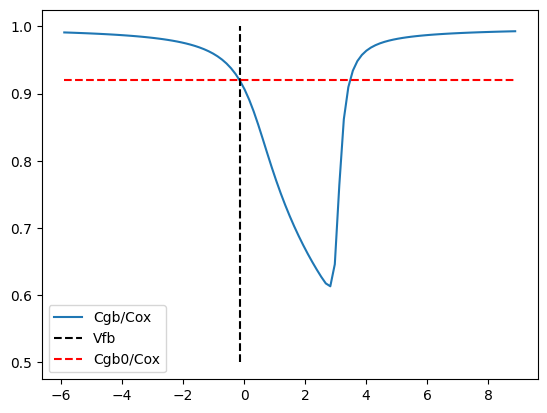

In [23]:
# the semiconductor capacitance at flatband
Cs0=np.sqrt(q*es*e0/kT*(po+no))
#f=lambda psis: kT*po*(np.exp(-psis/kT)-1)+kT*no*(np.exp(psis/kT)-1)+psis*(NA-ND)
df=lambda psis: -po*np.exp(-psis/kT)+no*np.exp(psis/kT)+(NA-ND)
Cs=lambda psis: np.sign(psis)*df(psis)*np.sqrt(q*es*e0/2/(f(psis)+I(psis)))+I(psis)*Cs0
Cgb=Cs(psis)*Cox/(Cs(psis)+Cox)
Cgb0=Cs(0)*Cox/(Cs(0)+Cox)

plt.plot(Vgb,Cgb/Cox,label="Cgb/Cox")
plt.plot([Vfb, Vfb],[0.5,1],'k--', label="Vfb")
plt.plot([Vgb[0],Vgb[-1]],[Cgb0/Cox,Cgb0/Cox],"r--", label="Cgb0/Cox")
plt.legend()
plt.show()

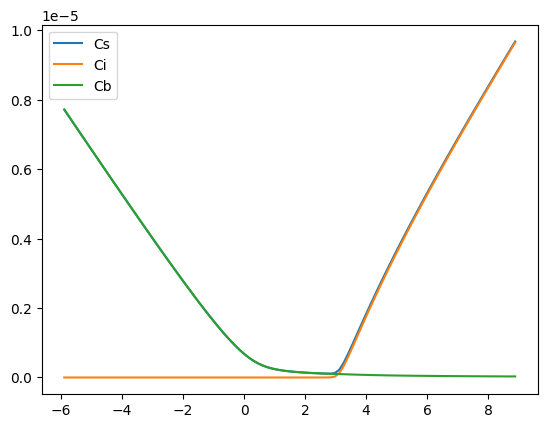

In [24]:
# Calculate the surface field via its relationship with semiconductor charge
Efields=Qs(psis)/(-es*e0)
if device_type=="NMOS":
    Cb0=np.sqrt(q*es*e0/kT*po)
    Ci0=np.sqrt(q*es*e0/kT*no)
    Ci=q*(n(psis)-no)/(Efields+I(psis))+I(psis)*Ci0
    Cb=-q*(p(psis)-po)/(Efields+I(psis))+I(psis)*Cb0
else:
    Cb0=np.sqrt(q*es*e0/kT*no)
    Ci0=np.sqrt(q*es*e0/kT*po)
    Ci=-q*(p(psis)-po)/(Efields+I(psis))+I(psis)*Ci0
    Cb=q*(n(psis)-no)/(Efields+I(psis))+I(psis)*Cb0

plt.plot(Vgb,Cs(psis), label="Cs")
plt.plot(Vgb,Ci, label="Ci")
plt.plot(Vgb,Cb, label="Cb")
plt.legend()
plt.show()